In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import  Statevector, random_statevector, SparsePauliOp
from qiskit.visualization import plot_bloch_multivector
from qiskit_experiments.library.tomography import StateTomography
from qiskit.primitives import Estimator
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel, amplitude_damping_error
from qiskit.providers.fake_provider import FakeVigo

from exact_diagonalization import *

**Exercise 6**

**(a)**

In [2]:
def evolve_basic(circ, g, dt):
    for i in range(circ.num_qubits - 1):
        circ.rzz(-dt, i, i+1)
    for i in range(circ.num_qubits):
        circ.rx(-g*dt, i)
    return circ

**(b)**

In [3]:
def evolve_symmetric(circ, g, dt):
    for i in range(circ.num_qubits):
        circ.rx(-g*dt/2, i)
    for i in range(circ.num_qubits - 1):
        circ.rzz(-dt, i, i+1)
    for i in range(circ.num_qubits):
        circ.rx(-g*dt/2, i)
    return circ

**Exercise 7**

In [4]:
def simulate_magnetization(L, g, t, dt):

    estimator = Estimator()

    observable = SparsePauliOp.from_sparse_list([("Z", [i] ,1) for i in range(L)], num_qubits=L)

    circ_basic, circ_symm = QuantumCircuit(L), QuantumCircuit(L)
    ms_basic, ms_symm =  list(), list()
    for _ in range(round(t//dt)):
        evolve_basic(circ_basic, g, dt)

        m = estimator.run(circ_basic, observable).result().values / L
        ms_basic.append(m)

        evolve_symmetric(circ_symm, g, dt)

        m = estimator.run(circ_symm, observable).result().values / L
        ms_symm.append(m)

    return ms_basic, ms_symm

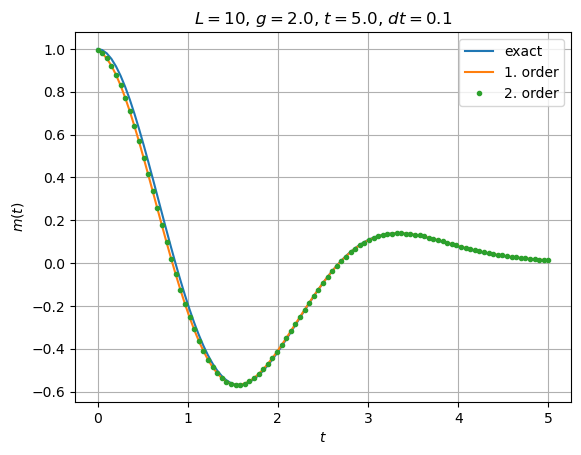

In [44]:
L, g, t, dt = 10, 2, 5, 0.05
ms_basic, ms_symm = simulate_magnetization(L, g, t, dt)
ms_exact = magn_exact_diagonalization(L, g, t, round(t//dt))


fig, ax = plt.subplots(1, 1)
ts = np.linspace(0, t, round(t//dt))
ax.plot(ts, ms_exact, '-', label='exact')
ax.plot(ts, ms_basic, '-', label='1. order')
ax.plot(ts, ms_symm, '.', label='2. order')
ax.set_title('$L=%d$, $g=%.1f$, $t=%.1f$, $dt=%.1f$'%(L, g, t, dt)), ax.set_xlabel("$t$"), ax.set_ylabel("$m(t)$"), ax.legend(), ax.grid();

**Exercise 8**

In [50]:
def simulate_rates(L, g, t, dt):

    steps = round(t//dt)
    circ = QuantumCircuit(L)

    λ0_list, λ1_list, λ_list =  list(), list(), list()
    for step in range(steps):

        evolve_basic(circ, g, dt)
        circ.save_statevector(label=str(step))

    sim = AerSimulator(method="statevector")
    result = sim.run(circ).result()

    for step in range(round(t//dt)):

        p = result.data()[str(step)].probabilities()
        p0, p1 = p[0], p[-1]
        λ0, λ1, λ = -np.log(p0)/L, -np.log(p1)/L, -np.log(p0 + p1)/L
        λ0_list.append(λ0), λ1_list.append(λ1), λ_list.append(λ)

    return λ0_list, λ1_list, λ_list

In [54]:
def simulate_rates_over_grid_and_plot(Ls, gs, t, dt):

    # simulate rates
    rates = {}
    for L in Ls:
        rates[L] = {}
        for g in gs:
            rates[L][g] = simulate_rates(L, g, t, dt)
            
    # plot results
    fig, axes = plt.subplots(3, 1, figsize=(12, 5))
    ts = np.linspace(0, t, round(t//dt))
    for k, ax in enumerate(axes):
        for L in Ls:
            for g in gs:
                ax.plot(ts, rates[L][g][k], '-', label='L=%d, g=%.2f'%(L, g))
        ax.set_ylabel("$\lambda(t)$" if k==2 else "$\lambda_{%d}(t)$"%(k)) 
        ax.grid()
    ax.set_xlabel("$t$")
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right')
    fig.subplots_adjust(wspace=1)
    fig.suptitle('$t=%.1f$, $dt=%.1f$'%(t, dt), fontsize="x-large")

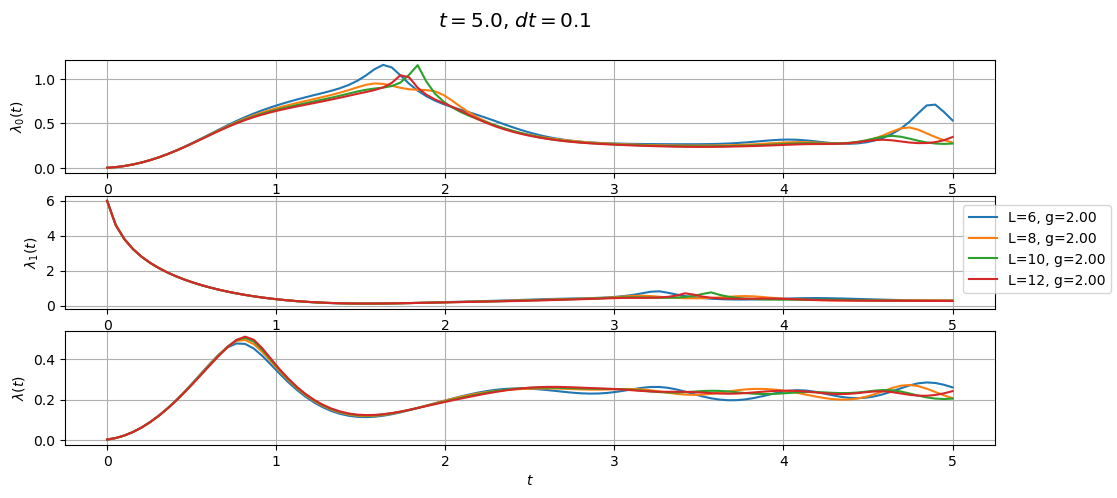

In [55]:
t, dt = 5, 0.05
Ls, gs = [6, 8, 10, 12], [2]

simulate_rates_over_grid_and_plot(Ls, gs, t, dt)

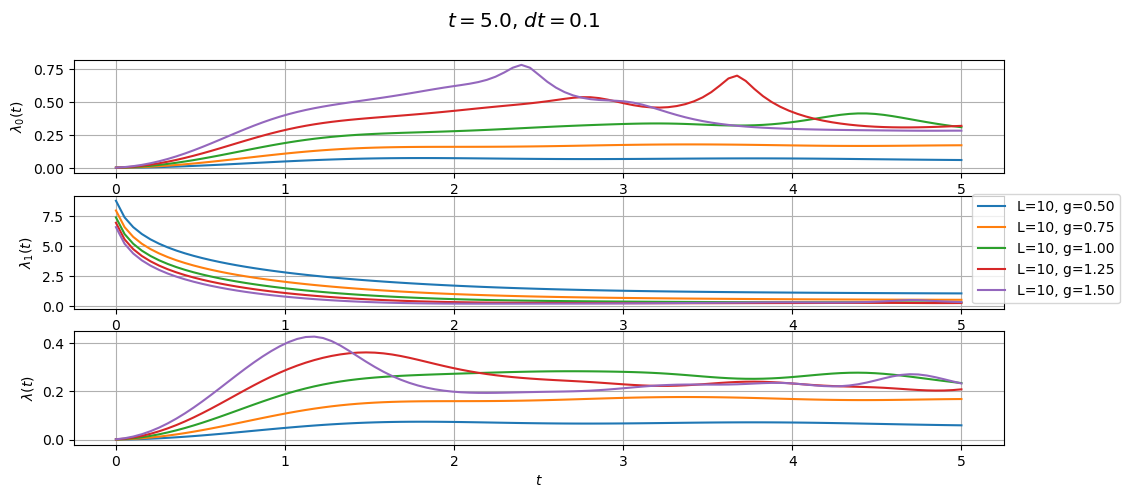

In [56]:
t, dt = 5, 0.05
Ls, gs = [10], [0.5, 0.75, 1.0, 1.25, 1.5]

simulate_rates_over_grid_and_plot(Ls, gs, t, dt)

**Exercise 9**

In [57]:
def measure_magnetization(L, g, t, dt, shots):

    estimator = Estimator()

    observable = SparsePauliOp.from_sparse_list([("Z", [i] ,1) for i in range(L)], num_qubits=L)

    circ_basic, circ_symm = QuantumCircuit(L), QuantumCircuit(L)
    ms_basic, ms_symm =  list(), list()
    for _ in range(round(t//dt)):
        evolve_basic(circ_basic, g, dt)

        m = estimator.run(circ_basic, observable, shots=shots).result().values / L
        ms_basic.append(m)

        evolve_symmetric(circ_symm, g, dt)

        m = estimator.run(circ_symm, observable, shots=shots).result().values / L
        ms_symm.append(m)

    return ms_basic, ms_symm

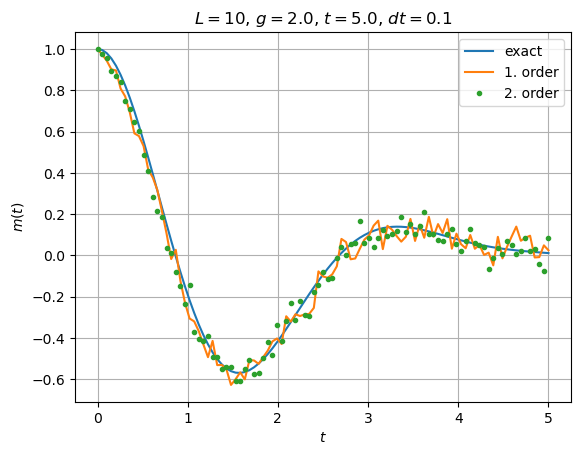

In [59]:
L, g, t, dt = 10, 2, 5, 0.05
ms_basic, ms_symm = measure_magnetization(L, g, t, dt, shots=100)
ms_exact = magn_exact_diagonalization(L, g, t, round(t//dt))


fig, ax = plt.subplots(1, 1)
ts = np.linspace(0, t, round(t//dt))
ax.plot(ts, ms_exact, '-', label='exact')
ax.plot(ts, ms_basic, '-', label='1. order')
ax.plot(ts, ms_symm, '.', label='2. order')
ax.set_title('$L=%d$, $g=%.1f$, $t=%.1f$, $dt=%.1f$'%(L, g, t, dt)), ax.set_xlabel("$t$"), ax.set_ylabel("$m(t)$"), ax.legend(), ax.grid();

In [100]:
def measure_rates(L, g, t, dt, shots):

    steps = round(t//dt)
    circ = QuantumCircuit(L)

    echos, λs = list(), list()
    for step in range(steps):

        evolve_basic(circ, g, dt)
        circ_tmp = circ.measure_all(inplace=False, add_bits=True)

        sim = AerSimulator()
        result = sim.run(circ_tmp, shots=shots).result()
        counts = result.get_counts(circ)
        p0, p1 = counts.get('0'*L, 0)/shots, counts.get('1'*L, 0)/shots
        echo = p0+p1
        echos.append(echo)
        λ = -np.log(echo)/L
        λs.append(λ)

    return echos, λs

In [101]:
def measure_rates_over_grid_and_plot(Ls, gs, t, dt, shots):

    # measure rates
    rates = {}
    for L in Ls:
        rates[L] = {}
        for g in gs:
            rates[L][g] = measure_rates(L, g, t, dt, shots)
            
    # plot results
    fig, ax = plt.subplots(1, 1)#, figsize=(12, 5))
    ts = np.linspace(0, t, round(t//dt))
    for L in Ls:
        for g in gs:
            ax.plot(ts, rates[L][g][0], '-', label='echo, L=%d, g=%.2f'%(L, g))
            ax.plot(ts, rates[L][g][1], '-', label='lambda, L=%d, g=%.2f'%(L, g))
    ax.set_ylabel("$\mathcal{L}(t)$") 
    ax.grid()
    ax.set_xlabel("$t$")
    ax.legend()

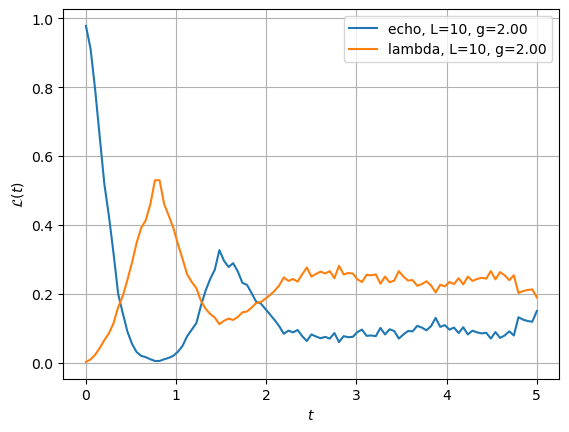

In [105]:
t, dt = 5, 0.05
Ls, gs = [10], [2]

measure_rates_over_grid_and_plot(Ls, gs, t, dt, shots=1000)

**Exercise 10**

In [103]:
t, dt = 5, 0.05
L, g = 10, 2

echos, λs = measure_rates(L, g, t, dt, shots=1000)

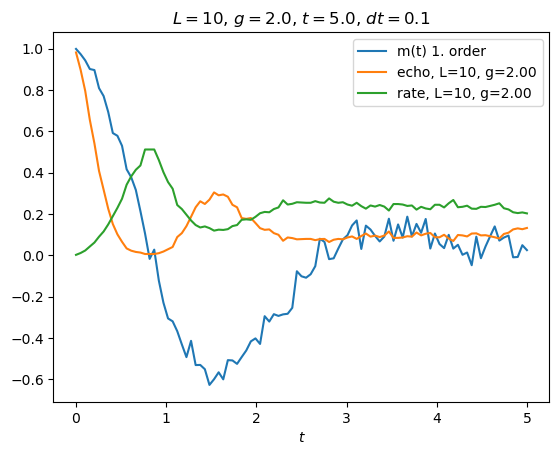

In [104]:
fig, ax = plt.subplots(1, 1)
ts = np.linspace(0, t, round(t//dt))
ax.plot(ts, ms_basic, '-', label='m(t) 1. order')
ax.plot(list(ts), echos, '-', label='echo, L=%d, g=%.2f'%(L, g))
ax.plot(ts, λs, '-', label='rate, L=%d, g=%.2f'%(L, g))
ax.grid()
ax.set_xlabel("$t$")
ax.legend()

ax.set_title('$L=%d$, $g=%.1f$, $t=%.1f$, $dt=%.1f$'%(L, g, t, dt)), ax.set_xlabel("$t$"), ax.legend(), ax.grid();